In [1]:
using CARMA
using Ensemble
using PyCall
using PyPlot

My favourite figure settings....

In [2]:
@pyimport seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")
sns.set_palette("colorblind")

## Load and Plot the Data

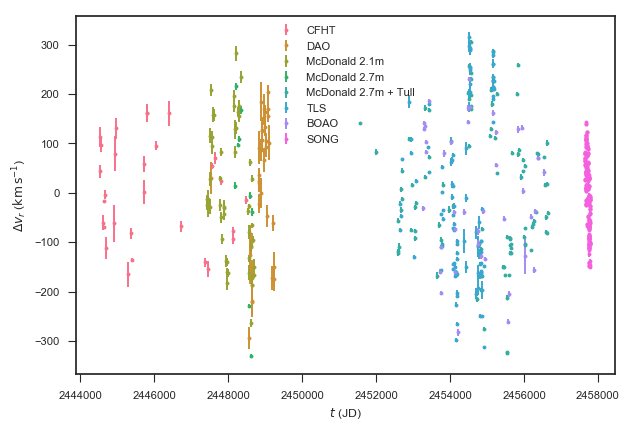

In [3]:
dsnames = ["CFHT", "DAO", "McDonald 2.1m", "McDonald 2.7m", "McDonald 2.7m + Tull", "TLS", "BOAO", "SONG"]
data = []
for i in 3:9
    push!(data, readdlm("../data/$i/table$(i).dat"))
end
push!(data, readdlm("../data/song/tablesong.dat"))
clrs = sns.color_palette("husl", length(data))
for (n, d, c) in zip(dsnames, data, clrs)
    errorbar(d[:,1], d[:,2] - mean(d[:,2]), d[:,3], fmt=".", label=n, color=c)
end
legend(loc="best")
xlabel(L"$t$ (JD)")
ylabel(L"$\Delta v_r$ ($\mathrm{km} \, \mathrm{s}^{-1}$)")
tight_layout()
savefig("../plots/all-data.pdf")

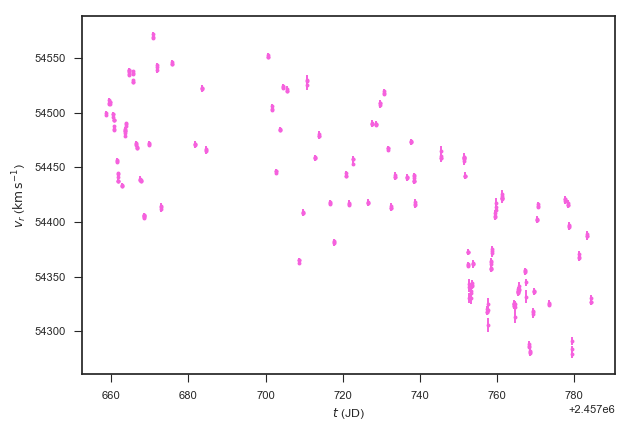

In [4]:
errorbar(data[end][:,1], data[end][:,2], data[end][:,3], fmt=".", color=clrs[end])
xlabel(L"$t$ (JD)")
ylabel(L"$v_r$ ($\mathrm{km} \, \mathrm{s}^{-1}$)")
tight_layout()
savefig("../plots/song-data.pdf")

## The Fits

In [4]:
# Need dummy functions for deserilazation
function logl(x)
    @assert false
end
function logp(x)
    @assert false
end

single_posts = []
single_nstates = []
single_postsamples = []
for i in 3:9
    p, n = open(deserialize, "../fits/single/$(i)/state-5-4.dat", "r")
    push!(single_posts, p)
    push!(single_nstates, n)
    push!(single_postsamples, EnsembleNest.postsample(n)[1])
end
p,n = open(deserialize, "../fits/single/song/state-5-4.dat", "r")
push!(single_posts, p)
push!(single_nstates, n)
push!(single_postsamples, EnsembleNest.postsample(n)[1])

presong_post, presong_nstate = open(deserialize, "../fits/pre-song/state-5-4.dat", "r")
presong_postsamples = EnsembleNest.postsample(presong_nstate)[1]

all_post, all_nstate = open(deserialize, "../fits/all/state-5-4.dat", "r")
all_postsamples = EnsembleNest.postsample(all_nstate)[1]

all_post76, all_nstate76 = open(deserialize, "../fits/all/state-7-6.dat", "r")
all_postsamples76 = EnsembleNest.postsample(all_nstate76)[1]
nothing

In [5]:
println(@sprintf("(5,4) ln(Z) = %.1f, (7,6) ln(Z) = %.1f", EnsembleNest.logZ(all_nstate)[1], EnsembleNest.logZ(all_nstate76)[1]))

(5,4) ln(Z) = -3006.4, (7,6) ln(Z) = -3022.0


This is such strong evidence in favour of $(5,4)$, let's look at the max likelihood to see if the $(7,6)$ somehow missed the peak:

In [6]:
println(@sprintf("(5,4) max(L) = %.1f, (7,6) max(L) = %.1f", maximum(all_nstate.livelogls), maximum(all_nstate76.livelogls)))

(5,4) max(L) = -2908.7, (7,6) max(L) = -2927.8


So, it looks like the $(7,6)$ just missed the peak in the likelihood; we should re-run/diagnose to see if there is some issue here.

## Single/Multiple PSD Comparison

In [7]:
function plot_psd(post, postsamples; fs=nothing, label=nothing, color=nothing)
    if fs == nothing
        fs = Kalman.psdfreq(post, nyquist_factor=5)
    end
    
    if size(postsamples, 2) > 1000
        postsamples = postsamples[:, randperm(size(postsamples, 2))]
        postsamples = postsamples[:, 1:1000]
    end
    
    psds = Kalman.psd(post, postsamples, fs)
    
    nfs = size(fs,1)
    llow = zeros(nfs)
    low = zeros(nfs)
    med = zeros(nfs)
    high = zeros(nfs)
    hhigh = zeros(nfs)
    
    for i in 1:nfs
        p = vec(psds[i,:])
        llow[i] = quantile(p, 0.025)
        low[i] = quantile(p, 0.16)
        med[i] = quantile(p, 0.5)
        high[i] = quantile(p, 0.84)
        hhigh[i] = quantile(p, 0.975)
    end
    
    plot(fs, med, label=label, color=color)
    fill_between(fs, high, low, color=color, alpha=0.1)
    fill_between(fs, hhigh, llow, color=color, alpha=0.1)
end

plot_psd (generic function with 1 method)

Here are the PSDs for the pre-SONG data, and the complete data set.  We need to investigate why the complete data set (incl SONG data) doesn't show the planetary RV signal. 

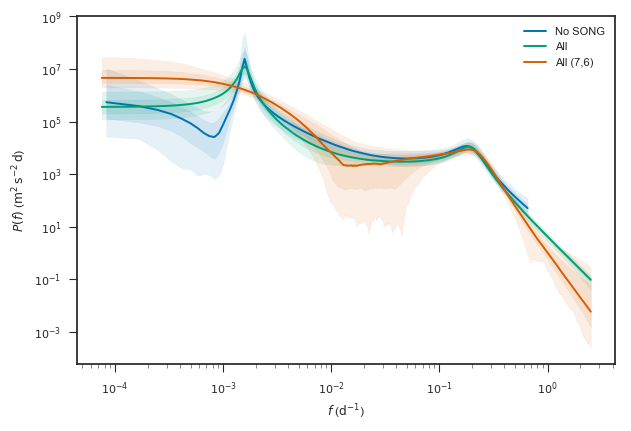

In [8]:
plot_psd(presong_post, presong_postsamples, label="No SONG", color=sns.color_palette()[1])
plot_psd(all_post, all_postsamples, label="All", color=sns.color_palette()[2])
plot_psd(all_post76, all_postsamples76, label="All (7,6)", color=sns.color_palette()[3])
xscale("log")
yscale("log")
xlabel(L"$f$ ($\mathrm{d}^{-1}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mathrm{d}$)")
legend(loc="best")
tight_layout()
savefig("../plots/all-psd-pre-post-song.pdf")

And here we see more evidence that the $(7,6)$ run missed the peak, since it doesn't have the planet peak in it.

Given that both data sets agree about the location of the $\nu_\mathrm{max}$ peak, let's zoom in:

In [10]:
fmin = 0.01 # per day
fmax = 1
fs = collect(logspace(log10(fmin), log10(fmax), 1000))
nothing

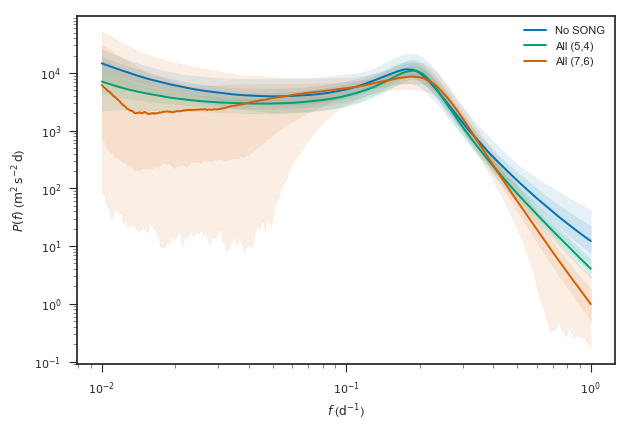

In [11]:
plot_psd(presong_post, presong_postsamples, fs=fs, label="No SONG", color=sns.color_palette()[1])
plot_psd(all_post, all_postsamples, fs=fs, label="All (5,4)", color=sns.color_palette()[2])
plot_psd(all_post76, all_postsamples76, fs=fs, label="All (7,6)", color=sns.color_palette()[3])
xscale("log")
yscale("log")
xlabel(L"$f$ ($\mathrm{d}^{-1}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mathrm{d}$)")
legend(loc="best")
tight_layout()
savefig("../plots/psd-pre-post-song.pdf")

These PDSs are consistent with each other, but I wonder if we might not benefit from high-pass filtering these data to eliminate any power at frequencies lower than $10^{-2} \, \mathrm{d}^{-1}$ before conducting the analysis.

Let's plot all the single-dataset results against each other in this frequency range:

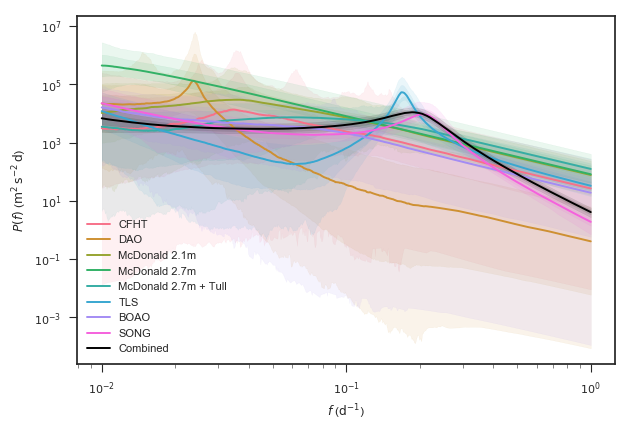

In [12]:
for (p, ps, n, c) in zip(single_posts, single_postsamples, dsnames, clrs)
    plot_psd(p, ps, label=n, color=c, fs=fs)
end
plot_psd(all_post, all_postsamples, fs=fs, label="Combined", color="k")
xscale("log")
yscale("log")
xlabel(L"$f$ ($\mathrm{d}^{-1}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mathrm{d}$)")
legend(loc="best")
tight_layout()
savefig("../plots/psd-single.pdf")

Let's have a look at the frequencies found in the combined and pre-SONG analyses:

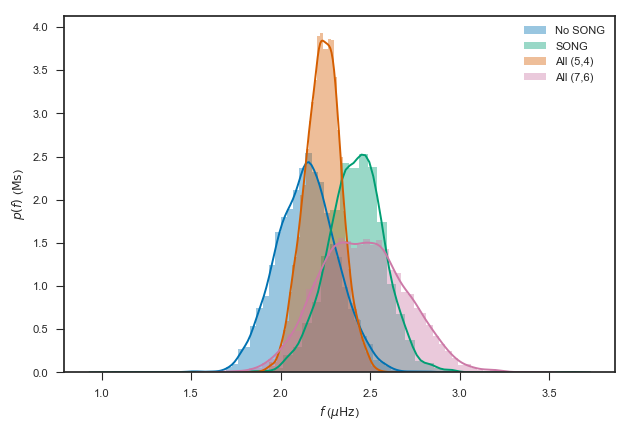

No SONG = 2.15 +/- 0.17 muHz
SONG = 2.42 +/- 0.16 muHz
All = 2.23 +/- 0.10 muHz
All (7,6) = 2.46 +/- 0.24 muHz


In [16]:
perday_to_muhz = 1.0/(3600.0*24.0*1e-6)
fssong = Kalman.frequencies(single_posts[end], single_postsamples[end])*perday_to_muhz
fspre = Kalman.frequencies(presong_post, presong_postsamples)*perday_to_muhz
fsall = Kalman.frequencies(all_post, all_postsamples)*perday_to_muhz
fsall76 = Kalman.frequencies(all_post76, all_postsamples76)*perday_to_muhz
fspre = fspre[(fspre.>1) & (fspre.<4)]
fsall = fsall[(fsall.>1) & (fsall.<4)]
fssong = fssong[(fssong.>1) & (fssong.<4)]
fsall76 = fsall76[(fsall76.>1) & (fsall76.<4)]
sns.distplot(fspre, label="No SONG")
sns.distplot(fssong, label="SONG")
sns.distplot(fsall, label="All (5,4)")
sns.distplot(fsall76, label="All (7,6)")
xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$p(f)$ ($\mathrm{Ms}$)")
legend(loc="best")
tight_layout()
savefig("../plots/numax.pdf")
writedlm("../fits/all/nu_max-5-4.dat", fsall)
println(@sprintf("No SONG = %.2f +/- %.2f muHz", mean(fspre), std(fspre)))
println(@sprintf("SONG = %.2f +/- %.2f muHz", mean(fssong), std(fssong)))
println(@sprintf("All = %.2f +/- %.2f muHz", mean(fsall), std(fsall)))
println(@sprintf("All (7,6) = %.2f +/- %.2f muHz", mean(fsall76), std(fsall76)))